# Neural Network Architecture Study - OPTIMIZED
## Paper 4 - Mit Preloading für schnellere Ausführung

**Optimierungen:**
- ✅ Daten werden in RAM vorgeladen
- ✅ Keine W&B Hook Probleme
- ✅ Schnellere Ausführung
- ✅ VS Code kompatibel

## 1. Setup & Imports

In [3]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import wandb
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import time
import pandas as pd
from datetime import datetime, timedelta

# ============================================
# GESAMTZEIT-MESSUNG START
# ============================================
NOTEBOOK_START_TIME = time.time()
START_DATETIME = datetime.now()

# Dictionary für Zeittracking einzelner Schritte
time_tracker = {
    'data_loading': 0,
    'experiments': {},
    'test_evaluation': 0
}

print("="*80)
print("⏱️  NOTEBOOK EXECUTION TIMER GESTARTET")
print("="*80)
print(f"Start Zeit: {START_DATETIME.strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80 + "\n")

# Konfiguration
RANDOM_SEED = 42
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"PyTorch: {torch.__version__}")
print(f"Device: {DEVICE}")
print(f"W&B: {wandb.__version__}")

⏱️  NOTEBOOK EXECUTION TIMER GESTARTET
Start Zeit: 2025-12-22 19:19:05

PyTorch: 2.9.1+cpu
Device: cpu
W&B: 0.23.1


## 2. W&B Login

In [4]:
# W&B Login
wandb.login(key="9f481d84dcd825d6666b930623275998ca89829e")
print("✅ W&B Login erfolgreich!")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Silver\_netrc
wandb: Currently logged in as: anouk347 (anouk347-university-of-applied-sciences-ansbach) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✅ W&B Login erfolgreich!


## 3. Data Loading mit PRELOADING

Hier laden wir ALLE Daten in den RAM - viel schneller!

In [5]:
# ============================================
# DATA LOADING MIT PRELOADING
# ============================================

data_loading_start = time.time()

print("📦 Lade Fashion-MNIST in den Arbeitsspeicher...")

# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Lade Daten
train_dataset_orig = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_dataset_orig = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

# Klassenamen
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# PRELOAD in RAM
print("⚡ Preloading in RAM...")

# Alle Daten in Tensoren laden
train_images = []
train_labels = []
for img, label in tqdm(train_dataset_orig, desc="Loading train"):
    train_images.append(img)
    train_labels.append(label)

test_images = []
test_labels = []
for img, label in tqdm(test_dataset_orig, desc="Loading test"):
    test_images.append(img)
    test_labels.append(label)

# Zu Tensoren konvertieren
train_images = torch.stack(train_images)
train_labels = torch.tensor(train_labels)
test_images = torch.stack(test_images)
test_labels = torch.tensor(test_labels)

# Train/Val Split
train_size = int(0.8 * len(train_images))
val_size = len(train_images) - train_size

# Split
indices = torch.randperm(len(train_images), generator=torch.Generator().manual_seed(RANDOM_SEED))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# DataLoaders mit preloaded Daten
train_loader = DataLoader(
    TensorDataset(train_images[train_indices], train_labels[train_indices]),
    batch_size=BATCH_SIZE, shuffle=True
)
val_loader = DataLoader(
    TensorDataset(train_images[val_indices], train_labels[val_indices]),
    batch_size=BATCH_SIZE, shuffle=False
)
test_loader = DataLoader(
    TensorDataset(test_images, test_labels),
    batch_size=BATCH_SIZE, shuffle=False
)

# Zeit tracken
time_tracker['data_loading'] = time.time() - data_loading_start

print(f"✅ Daten geladen!")
print(f"Train: {len(train_indices)}, Val: {len(val_indices)}, Test: {len(test_labels)}")
print(f"⏱️  Data Loading Zeit: {time_tracker['data_loading']:.1f}s ({time_tracker['data_loading']/60:.1f} min)")

📦 Lade Fashion-MNIST in den Arbeitsspeicher...
⚡ Preloading in RAM...


Loading test: 100%|██████████| 10000/10000 [00:02<00:00, 3449.92it/s]


✅ Daten geladen!
Train: 48000, Val: 12000, Test: 10000
⏱️  Data Loading Zeit: 20.7s (0.3 min)


## 4. Model Architectures

In [6]:
# ============================================
# MODEL ARCHITECTURES
# ============================================

class SimpleMLP(nn.Module):
    """Architecture A: Simple MLP"""
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.layers(x)

class DeepMLP(nn.Module):
    """Architecture B: Deep MLP"""
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
    def forward(self, x):
        return self.layers(x)

class VariableMLP(nn.Module):
    """MLP mit variabler Breite"""
    def __init__(self, hidden_size=128):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 10)
        )
    def forward(self, x):
        return self.layers(x)

class SimpleCNN(nn.Module):
    """Architecture C: Simple CNN"""
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 14 * 14, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

class DeeperCNN(nn.Module):
    """Architecture D: Deeper CNN mit BatchNorm"""
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

class CNNWithDropout(nn.Module):
    """CNN mit Dropout"""
    def __init__(self, dropout_rate=0.3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 10)
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("✅ Models definiert!")

✅ Models definiert!


## 5. Training Function (OHNE W&B Hooks - behebt das Problem!)

In [7]:
# ============================================
# TRAINING FUNCTION (Optimiert, ohne W&B Hooks)
# ============================================

def train_model(model, config, project_name="Paper_4"):
    """Trainiert Modell und loggt zu W&B - OHNE wandb.watch()"""
    
    # Experiment-spezifischer Timer
    exp_start_time = time.time()
    exp_name = config.get('run_name', 'experiment')
    
    # W&B init
    run = wandb.init(
        project=project_name,
        config=config,
        name=exp_name,
        reinit=True
    )
    
    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.get('learning_rate', LEARNING_RATE))
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'epoch_times': []}
    best_val_acc = 0.0
    start_time = time.time()
    
    for epoch in range(config.get('epochs', EPOCHS)):
        epoch_start = time.time()
        
        # Training
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{config.get("epochs", EPOCHS)}', leave=False):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # Metrics
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_accuracy = 100 * train_correct / train_total
        val_accuracy = 100 * val_correct / val_total
        epoch_time = time.time() - epoch_start
        
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)
        history['epoch_times'].append(epoch_time)
        
        # Log to W&B
        wandb.log({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'train_accuracy': train_accuracy,
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy,
            'train_val_gap': train_accuracy - val_accuracy,
            'epoch_time': epoch_time
        })
        
        print(f'Epoch {epoch+1}/{config.get("epochs", EPOCHS)} | '
              f'Train: {train_accuracy:.2f}% | Val: {val_accuracy:.2f}% | Time: {epoch_time:.1f}s')
        
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
    
    total_time = time.time() - start_time
    
    # Summary
    wandb.summary.update({
        'best_val_accuracy': best_val_acc,
        'final_val_accuracy': val_accuracy,
        'total_time': total_time,
        'parameters': count_parameters(model)
    })
    
    # Speichere Experiment-Zeit im globalen Tracker
    exp_total_time = time.time() - exp_start_time
    time_tracker['experiments'][exp_name] = exp_total_time
    
    print(f'✅ Training Complete! Best Val Acc: {best_val_acc:.2f}%')
    print(f'⏱️  Experiment Zeit: {exp_total_time:.1f}s ({exp_total_time/60:.1f} min)')
    wandb.finish()
    
    return history, model

print("✅ Training function ready!")

✅ Training function ready!


## 6. Experiment 1: MLP Depth & Width Study

In [8]:
# Experiment 1.1: Simple MLP
print("🔬 Experiment 1.1: Simple MLP")
config = {'run_name': 'exp1.1-simple-mlp', 'architecture': 'Simple MLP', 
          'epochs': 20, 'learning_rate': 0.001}
history_simple, model_simple = train_model(SimpleMLP(), config)

🔬 Experiment 1.1: Simple MLP


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch 1/20 | Train: 81.30% | Val: 84.14% | Time: 3.1s


Epoch 2/20 | Train: 85.71% | Val: 86.34% | Time: 3.4s


Epoch 3/20 | Train: 87.00% | Val: 86.54% | Time: 3.0s


Epoch 4/20 | Train: 87.84% | Val: 87.00% | Time: 3.1s


Epoch 5/20 | Train: 88.55% | Val: 87.59% | Time: 3.1s


Epoch 6/20 | Train: 89.06% | Val: 87.08% | Time: 3.0s


Epoch 7/20 | Train: 89.69% | Val: 87.77% | Time: 3.2s


Epoch 8/20 | Train: 90.02% | Val: 87.82% | Time: 3.0s


Epoch 9/20 | Train: 90.45% | Val: 88.47% | Time: 3.0s


Epoch 10/20 | Train: 90.83% | Val: 87.99% | Time: 3.0s


Epoch 11/20 | Train: 91.15% | Val: 88.63% | Time: 3.0s


Epoch 12/20 | Train: 91.50% | Val: 88.50% | Time: 3.0s


Epoch 13/20 | Train: 91.67% | Val: 87.53% | Time: 3.1s


Epoch 14/20 | Train: 92.00% | Val: 88.02% | Time: 2.9s


Epoch 15/20 | Train: 92.45% | Val: 88.89% | Time: 3.0s


Epoch 16/20 | Train: 92.43% | Val: 88.60% | Time: 2.9s


Epoch 17/20 | Train: 92.88% | Val: 88.50% | Time: 2.9s


Epoch 18/20 | Train: 93.13% | Val: 88.16% | Time: 3.1s


Epoch 19/20 | Train: 93.34% | Val: 88.77% | Time: 3.0s


Epoch 20/20 | Train: 93.40% | Val: 88.68% | Time: 3.1s
✅ Training Complete! Best Val Acc: 88.89%
⏱️  Experiment Zeit: 70.8s (1.2 min)


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_time,▄█▃▄▃▂▅▂▃▃▃▂▃▁▂▂▂▄▂▄
train_accuracy,▁▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇████
train_loss,█▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
train_val_gap,▁▃▄▄▄▅▅▆▅▆▆▆▇▇▇▇▇███
val_accuracy,▁▄▅▅▆▅▆▆▇▇█▇▆▇██▇▇██
val_loss,█▄▄▃▃▃▂▂▁▂▁▂▃▂▂▂▂▃▃▃
best_val_accuracy,88.89167
epoch,20
epoch_time,3.10056
final_val_accuracy,88.68333


In [9]:
# Experiment 1.2: Deep MLP
print("🔬 Experiment 1.2: Deep MLP")
config = {'run_name': 'exp1.2-deep-mlp', 'architecture': 'Deep MLP',
          'epochs': 20, 'learning_rate': 0.001}
history_deep, model_deep = train_model(DeepMLP(), config)

🔬 Experiment 1.2: Deep MLP


Epoch 1/20 | Train: 80.10% | Val: 83.07% | Time: 6.6s


Epoch 2/20 | Train: 85.84% | Val: 86.28% | Time: 7.6s


Epoch 3/20 | Train: 87.19% | Val: 86.92% | Time: 5.2s


Epoch 4/20 | Train: 87.98% | Val: 86.12% | Time: 7.4s


Epoch 5/20 | Train: 88.72% | Val: 87.34% | Time: 6.1s


Epoch 6/20 | Train: 89.26% | Val: 88.24% | Time: 5.9s


Epoch 7/20 | Train: 89.88% | Val: 88.08% | Time: 6.1s


Epoch 8/20 | Train: 90.25% | Val: 87.63% | Time: 6.0s


Epoch 9/20 | Train: 90.60% | Val: 88.92% | Time: 5.9s


Epoch 10/20 | Train: 91.15% | Val: 88.87% | Time: 5.6s


Epoch 11/20 | Train: 91.57% | Val: 88.68% | Time: 5.2s


Epoch 12/20 | Train: 91.86% | Val: 88.67% | Time: 5.0s


Epoch 13/20 | Train: 92.33% | Val: 88.89% | Time: 5.0s


Epoch 14/20 | Train: 92.33% | Val: 88.34% | Time: 5.2s


Epoch 15/20 | Train: 92.75% | Val: 88.97% | Time: 4.9s


Epoch 16/20 | Train: 93.02% | Val: 88.48% | Time: 4.9s


Epoch 17/20 | Train: 93.28% | Val: 89.29% | Time: 4.8s


Epoch 18/20 | Train: 93.59% | Val: 89.05% | Time: 5.0s


Epoch 19/20 | Train: 94.01% | Val: 88.92% | Time: 5.2s


Epoch 20/20 | Train: 94.12% | Val: 89.48% | Time: 5.1s
✅ Training Complete! Best Val Acc: 89.48%
⏱️  Experiment Zeit: 117.3s (2.0 min)


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_time,▅█▂█▄▄▄▄▄▃▂▁▁▂▁▁▁▁▂▂
train_accuracy,▁▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
train_loss,█▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
train_val_gap,▁▃▄▅▅▄▅▆▅▆▆▆▇▇▇█▇███
val_accuracy,▁▅▅▄▆▇▆▆▇▇▇▇▇▇▇▇██▇█
val_loss,█▄▄▄▃▂▂▂▁▁▂▂▁▂▃▃▃▃▃▄
best_val_accuracy,89.48333
epoch,20
epoch_time,5.101
final_val_accuracy,89.48333


In [10]:
# Experiment 1.3: Width Comparison
print("🔬 Experiment 1.3: MLP Width Study")
width_experiments = [64, 128, 256, 512]
width_histories = {}

for width in width_experiments:
    print(f"\n📊 Training MLP width={width}")
    config = {'run_name': f'exp1.3-mlp-width-{width}', 
              'architecture': f'MLP Width={width}',
              'hidden_size': width, 'epochs': 20, 'learning_rate': 0.001}
    history, _ = train_model(VariableMLP(width), config)
    width_histories[width] = history

🔬 Experiment 1.3: MLP Width Study

📊 Training MLP width=64


Epoch 1/20 | Train: 81.11% | Val: 83.81% | Time: 2.9s


Epoch 2/20 | Train: 85.49% | Val: 85.51% | Time: 2.6s


Epoch 3/20 | Train: 86.53% | Val: 86.10% | Time: 2.7s


Epoch 4/20 | Train: 87.61% | Val: 87.34% | Time: 2.6s


Epoch 5/20 | Train: 88.06% | Val: 87.26% | Time: 2.8s


Epoch 6/20 | Train: 88.54% | Val: 87.55% | Time: 2.8s


Epoch 7/20 | Train: 89.01% | Val: 86.32% | Time: 2.7s


Epoch 8/20 | Train: 89.42% | Val: 87.72% | Time: 2.6s


Epoch 9/20 | Train: 89.72% | Val: 87.47% | Time: 2.7s


Epoch 10/20 | Train: 90.03% | Val: 88.18% | Time: 2.6s


Epoch 11/20 | Train: 90.40% | Val: 88.20% | Time: 2.7s


Epoch 12/20 | Train: 90.55% | Val: 88.33% | Time: 2.7s


Epoch 13/20 | Train: 91.01% | Val: 88.07% | Time: 2.6s


Epoch 14/20 | Train: 91.24% | Val: 88.19% | Time: 2.6s


Epoch 15/20 | Train: 91.20% | Val: 87.71% | Time: 2.7s


Epoch 16/20 | Train: 91.40% | Val: 88.09% | Time: 2.7s


Epoch 17/20 | Train: 91.70% | Val: 88.37% | Time: 2.7s


Epoch 18/20 | Train: 92.00% | Val: 88.43% | Time: 2.6s


Epoch 19/20 | Train: 92.02% | Val: 88.23% | Time: 2.7s


Epoch 20/20 | Train: 92.22% | Val: 88.42% | Time: 2.7s
✅ Training Complete! Best Val Acc: 88.43%
⏱️  Experiment Zeit: 58.3s (1.0 min)


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_time,█▂▃▂▅▅▃▂▂▂▃▄▁▂▄▂▄▁▄▃
train_accuracy,▁▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇████
train_loss,█▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
train_val_gap,▁▄▄▄▅▅▇▆▆▆▆▆▇▇█▇████
val_accuracy,▁▄▄▆▆▇▅▇▇███▇█▇▇████
val_loss,█▅▄▃▃▂▄▂▃▁▂▁▂▂▂▃▂▂▂▂
best_val_accuracy,88.43333
epoch,20
epoch_time,2.69901
final_val_accuracy,88.425



📊 Training MLP width=128


Epoch 1/20 | Train: 81.50% | Val: 84.53% | Time: 3.2s


Epoch 2/20 | Train: 85.76% | Val: 86.17% | Time: 3.1s


Epoch 3/20 | Train: 87.18% | Val: 86.73% | Time: 3.0s


Epoch 4/20 | Train: 87.90% | Val: 87.13% | Time: 3.0s


Epoch 5/20 | Train: 88.64% | Val: 86.84% | Time: 3.0s


Epoch 6/20 | Train: 89.02% | Val: 87.06% | Time: 3.0s


Epoch 7/20 | Train: 89.49% | Val: 87.47% | Time: 3.0s


Epoch 8/20 | Train: 89.99% | Val: 88.16% | Time: 3.1s


Epoch 9/20 | Train: 90.45% | Val: 88.81% | Time: 3.5s


Epoch 10/20 | Train: 90.74% | Val: 87.61% | Time: 3.2s


Epoch 11/20 | Train: 91.06% | Val: 88.53% | Time: 2.9s


Epoch 12/20 | Train: 91.44% | Val: 88.36% | Time: 3.0s


Epoch 13/20 | Train: 91.72% | Val: 88.76% | Time: 2.9s


Epoch 14/20 | Train: 91.95% | Val: 88.50% | Time: 2.8s


Epoch 15/20 | Train: 92.07% | Val: 88.83% | Time: 3.1s


Epoch 16/20 | Train: 92.48% | Val: 88.56% | Time: 2.9s


Epoch 17/20 | Train: 92.76% | Val: 88.72% | Time: 3.0s


Epoch 18/20 | Train: 92.99% | Val: 88.59% | Time: 3.2s


Epoch 19/20 | Train: 93.17% | Val: 89.08% | Time: 3.0s


Epoch 20/20 | Train: 93.35% | Val: 88.83% | Time: 3.4s
✅ Training Complete! Best Val Acc: 89.08%
⏱️  Experiment Zeit: 65.6s (1.1 min)


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_time,▄▃▃▃▃▃▃▃█▅▂▂▂▁▃▂▂▄▃▆
train_accuracy,▁▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss,█▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
train_val_gap,▁▃▄▅▅▆▆▆▅▇▆▇▇▇▇▇████
val_accuracy,▁▄▄▅▅▅▆▇█▆▇▇█▇█▇▇▇██
val_loss,█▅▄▃▄▄▂▂▁▃▂▂▁▂▂▂▃▃▂▃
best_val_accuracy,89.075
epoch,20
epoch_time,3.35034
final_val_accuracy,88.83333



📊 Training MLP width=256


Epoch 1/20 | Train: 81.79% | Val: 85.14% | Time: 4.0s


Epoch 2/20 | Train: 85.97% | Val: 85.17% | Time: 3.6s


Epoch 3/20 | Train: 87.40% | Val: 87.36% | Time: 3.8s


Epoch 4/20 | Train: 88.30% | Val: 88.26% | Time: 3.8s


Epoch 5/20 | Train: 89.06% | Val: 87.89% | Time: 3.7s


Epoch 6/20 | Train: 89.60% | Val: 88.27% | Time: 3.9s


Epoch 7/20 | Train: 90.08% | Val: 87.85% | Time: 3.5s


Epoch 8/20 | Train: 90.44% | Val: 88.46% | Time: 3.8s


Epoch 9/20 | Train: 90.92% | Val: 88.61% | Time: 3.7s


Epoch 10/20 | Train: 91.45% | Val: 88.44% | Time: 3.7s


Epoch 11/20 | Train: 91.36% | Val: 88.91% | Time: 3.6s


Epoch 12/20 | Train: 92.20% | Val: 89.26% | Time: 3.8s


Epoch 13/20 | Train: 92.46% | Val: 89.52% | Time: 3.8s


Epoch 14/20 | Train: 92.65% | Val: 89.08% | Time: 3.7s


Epoch 15/20 | Train: 92.85% | Val: 88.93% | Time: 3.6s


Epoch 16/20 | Train: 93.19% | Val: 89.17% | Time: 5.7s


Epoch 17/20 | Train: 93.52% | Val: 88.66% | Time: 5.6s


Epoch 18/20 | Train: 93.68% | Val: 88.12% | Time: 9.3s


Epoch 19/20 | Train: 93.81% | Val: 89.53% | Time: 4.2s


Epoch 20/20 | Train: 94.13% | Val: 89.36% | Time: 5.3s
✅ Training Complete! Best Val Acc: 89.53%
⏱️  Experiment Zeit: 90.5s (1.5 min)


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_time,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▄█▂▃
train_accuracy,▁▃▄▅▅▅▆▆▆▆▆▇▇▇▇▇████
train_loss,█▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
train_val_gap,▁▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇█▇▇
val_accuracy,▁▁▅▆▅▆▅▆▇▆▇██▇▇▇▇▆██
val_loss,█▇▄▃▂▂▄▂▁▂▂▁▁▂▃▃▃▄▂▄
best_val_accuracy,89.53333
epoch,20
epoch_time,5.25319
final_val_accuracy,89.35833



📊 Training MLP width=512


Epoch 1/20 | Train: 82.24% | Val: 85.44% | Time: 7.1s


Epoch 2/20 | Train: 86.24% | Val: 85.76% | Time: 5.6s


Epoch 3/20 | Train: 87.36% | Val: 87.12% | Time: 5.6s


Epoch 4/20 | Train: 88.41% | Val: 87.75% | Time: 5.6s


Epoch 5/20 | Train: 88.98% | Val: 87.03% | Time: 6.1s


Epoch 6/20 | Train: 89.85% | Val: 88.17% | Time: 5.4s


Epoch 7/20 | Train: 90.22% | Val: 88.24% | Time: 6.2s


Epoch 8/20 | Train: 90.83% | Val: 88.89% | Time: 5.7s


Epoch 9/20 | Train: 91.24% | Val: 88.98% | Time: 5.6s


Epoch 10/20 | Train: 91.64% | Val: 88.25% | Time: 5.5s


Epoch 11/20 | Train: 92.19% | Val: 88.81% | Time: 5.4s


Epoch 12/20 | Train: 92.37% | Val: 88.90% | Time: 5.5s


Epoch 13/20 | Train: 92.66% | Val: 88.79% | Time: 6.1s


Epoch 14/20 | Train: 92.96% | Val: 87.94% | Time: 5.4s


Epoch 15/20 | Train: 93.20% | Val: 88.85% | Time: 5.5s


Epoch 16/20 | Train: 93.36% | Val: 88.73% | Time: 5.5s


Epoch 17/20 | Train: 93.85% | Val: 88.17% | Time: 5.5s


Epoch 18/20 | Train: 94.06% | Val: 89.22% | Time: 5.5s


Epoch 19/20 | Train: 94.21% | Val: 89.30% | Time: 5.6s


Epoch 20/20 | Train: 94.45% | Val: 88.74% | Time: 5.7s
✅ Training Complete! Best Val Acc: 89.30%
⏱️  Experiment Zeit: 119.9s (2.0 min)


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_time,█▂▂▂▄▁▄▂▂▁▁▂▄▁▂▁▁▁▂▂
train_accuracy,▁▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss,█▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
train_val_gap,▁▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇█▇▇█
val_accuracy,▁▂▄▅▄▆▆▇▇▆▇▇▇▆▇▇▆██▇
val_loss,█▇▄▃▄▃▂▁▁▂▁▂▃▅▃▃▆▃▄▆
best_val_accuracy,89.3
epoch,20
epoch_time,5.71863
final_val_accuracy,88.74167


## 7. Experiment 2: MLP vs CNN

In [11]:
# Experiment 2.1: Simple CNN
print("🔬 Experiment 2.1: Simple CNN")
config = {'run_name': 'exp2.1-simple-cnn', 'architecture': 'Simple CNN',
          'epochs': 20, 'learning_rate': 0.001}
history_simple_cnn, model_simple_cnn = train_model(SimpleCNN(), config)

🔬 Experiment 2.1: Simple CNN


Epoch 1/20 | Train: 84.84% | Val: 88.62% | Time: 30.5s


Epoch 2/20 | Train: 89.56% | Val: 89.72% | Time: 31.6s


Epoch 3/20 | Train: 91.02% | Val: 90.88% | Time: 34.4s


Epoch 4/20 | Train: 92.30% | Val: 91.20% | Time: 32.2s


Epoch 5/20 | Train: 93.05% | Val: 90.69% | Time: 32.3s


Epoch 6/20 | Train: 93.89% | Val: 90.73% | Time: 32.1s


Epoch 7/20 | Train: 94.70% | Val: 90.81% | Time: 32.9s


Epoch 8/20 | Train: 95.27% | Val: 91.37% | Time: 32.2s


Epoch 9/20 | Train: 96.04% | Val: 91.32% | Time: 33.6s


Epoch 10/20 | Train: 96.71% | Val: 90.97% | Time: 33.7s


Epoch 11/20 | Train: 97.11% | Val: 91.06% | Time: 33.7s


Epoch 12/20 | Train: 97.52% | Val: 90.50% | Time: 33.6s


Epoch 13/20 | Train: 97.81% | Val: 91.32% | Time: 41.8s


Epoch 14/20 | Train: 98.18% | Val: 91.24% | Time: 34.0s


Epoch 15/20 | Train: 98.50% | Val: 91.38% | Time: 31.8s


Epoch 16/20 | Train: 98.54% | Val: 91.47% | Time: 32.5s


Epoch 17/20 | Train: 98.83% | Val: 91.42% | Time: 33.4s


Epoch 18/20 | Train: 98.87% | Val: 90.70% | Time: 32.3s


Epoch 19/20 | Train: 99.07% | Val: 91.51% | Time: 32.5s


Epoch 20/20 | Train: 99.08% | Val: 91.25% | Time: 32.4s
✅ Training Complete! Best Val Acc: 91.51%
⏱️  Experiment Zeit: 667.7s (11.1 min)


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_time,▁▂▃▂▂▂▂▂▃▃▃▃█▃▂▂▃▂▂▂
train_accuracy,▁▃▄▅▅▅▆▆▇▇▇▇▇███████
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
train_val_gap,▁▃▃▄▅▅▅▆▆▇▇▇▇▇▇▇████
val_accuracy,▁▄▆▇▆▆▆██▇▇▆█▇███▆█▇
val_loss,▃▂▁▁▂▁▂▁▂▃▃▄▄▅▅▆▆█▇█
best_val_accuracy,91.50833
epoch,20
epoch_time,32.38884
final_val_accuracy,91.25


In [12]:
# Experiment 2.2: Deeper CNN
print("🔬 Experiment 2.2: Deeper CNN")
config = {'run_name': 'exp2.2-deeper-cnn', 'architecture': 'Deeper CNN',
          'epochs': 20, 'learning_rate': 0.001}
history_deeper_cnn, model_deeper_cnn = train_model(DeeperCNN(), config)

🔬 Experiment 2.2: Deeper CNN


Epoch 1/20 | Train: 85.69% | Val: 89.47% | Time: 63.4s


Epoch 2/20 | Train: 90.25% | Val: 90.37% | Time: 65.1s


Epoch 3/20 | Train: 91.56% | Val: 91.02% | Time: 66.8s


Epoch 4/20 | Train: 92.85% | Val: 91.37% | Time: 64.6s


Epoch 5/20 | Train: 93.50% | Val: 90.06% | Time: 64.4s


Epoch 6/20 | Train: 94.34% | Val: 91.38% | Time: 65.8s


Epoch 7/20 | Train: 95.26% | Val: 92.56% | Time: 64.4s


Epoch 8/20 | Train: 95.86% | Val: 92.03% | Time: 65.7s


Epoch 9/20 | Train: 96.57% | Val: 92.33% | Time: 64.5s


Epoch 10/20 | Train: 97.04% | Val: 91.97% | Time: 64.5s


Epoch 11/20 | Train: 97.51% | Val: 92.02% | Time: 63.8s


Epoch 12/20 | Train: 97.84% | Val: 92.22% | Time: 63.4s


Epoch 13/20 | Train: 98.23% | Val: 92.81% | Time: 64.8s


Epoch 14/20 | Train: 98.36% | Val: 92.10% | Time: 63.2s


Epoch 15/20 | Train: 98.64% | Val: 92.23% | Time: 63.5s


Epoch 16/20 | Train: 98.96% | Val: 92.28% | Time: 63.6s


Epoch 17/20 | Train: 99.03% | Val: 92.29% | Time: 63.8s


Epoch 18/20 | Train: 99.00% | Val: 92.29% | Time: 63.6s


Epoch 19/20 | Train: 99.06% | Val: 92.14% | Time: 63.0s


Epoch 20/20 | Train: 99.16% | Val: 91.82% | Time: 63.3s
✅ Training Complete! Best Val Acc: 92.81%
⏱️  Experiment Zeit: 1290.2s (21.5 min)


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_time,▂▅█▄▄▆▃▆▄▄▃▂▄▁▂▂▂▂▁▂
train_accuracy,▁▃▄▅▅▅▆▆▇▇▇▇████████
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
train_val_gap,▁▃▄▄▆▅▅▆▆▇▇▇▇▇▇█████
val_accuracy,▁▃▄▅▂▅▇▆▇▆▆▇█▇▇▇▇▇▇▆
val_loss,▃▂▂▁▃▂▁▁▂▃▃▄▃▅▅▅▆▇▇█
best_val_accuracy,92.80833
epoch,20
epoch_time,63.28179
final_val_accuracy,91.81667


## 8. Experiment 3: Regularization (Dropout)

In [13]:
# Experiment 3: Dropout Study
print("🔬 Experiment 3: Dropout Study")
dropout_rates = [0.0, 0.2, 0.3, 0.5]
dropout_histories = {}

for dropout in dropout_rates:
    print(f"\n📊 Training CNN with dropout={dropout}")
    config = {'run_name': f'exp3-dropout-{dropout}', 'dropout': dropout,
              'epochs': 20, 'learning_rate': 0.001}
    history, _ = train_model(CNNWithDropout(dropout), config)
    dropout_histories[dropout] = history

🔬 Experiment 3: Dropout Study

📊 Training CNN with dropout=0.0


Epoch 1/20 | Train: 85.91% | Val: 90.03% | Time: 62.5s


Epoch 2/20 | Train: 90.24% | Val: 88.38% | Time: 66.0s


Epoch 3/20 | Train: 91.56% | Val: 91.20% | Time: 63.9s


Epoch 4/20 | Train: 92.97% | Val: 92.14% | Time: 63.9s


Epoch 5/20 | Train: 93.86% | Val: 91.12% | Time: 63.9s


Epoch 6/20 | Train: 94.55% | Val: 91.60% | Time: 63.7s


Epoch 7/20 | Train: 95.41% | Val: 92.33% | Time: 63.8s


Epoch 8/20 | Train: 96.18% | Val: 92.46% | Time: 63.1s


Epoch 9/20 | Train: 96.77% | Val: 92.42% | Time: 66.9s


Epoch 10/20 | Train: 97.19% | Val: 91.65% | Time: 64.6s


Epoch 11/20 | Train: 97.65% | Val: 92.72% | Time: 68.6s


Epoch 12/20 | Train: 98.10% | Val: 92.53% | Time: 63.4s


Epoch 13/20 | Train: 98.35% | Val: 92.33% | Time: 72.4s


Epoch 14/20 | Train: 98.63% | Val: 92.18% | Time: 62.8s


Epoch 15/20 | Train: 98.96% | Val: 92.10% | Time: 63.4s


Epoch 16/20 | Train: 98.80% | Val: 92.49% | Time: 63.4s


Epoch 17/20 | Train: 98.97% | Val: 92.33% | Time: 63.1s


Epoch 18/20 | Train: 99.22% | Val: 91.83% | Time: 63.0s


Epoch 19/20 | Train: 99.05% | Val: 92.03% | Time: 63.9s


Epoch 20/20 | Train: 99.23% | Val: 92.03% | Time: 62.7s
✅ Training Complete! Best Val Acc: 92.72%
⏱️  Experiment Zeit: 1293.4s (21.6 min)


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_time,▁▃▂▂▂▂▂▁▄▃▅▂█▁▂▂▁▁▂▁
train_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇████████
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁
train_val_gap,▁▅▄▄▅▅▅▆▆▇▇▇▇▇█▇████
val_accuracy,▄▁▆▇▅▆▇██▆██▇▇▇█▇▇▇▇
val_loss,▃▄▂▁▂▂▁▁▂▄▂▃▃▅▆▆▆█▇█
best_val_accuracy,92.71667
epoch,20
epoch_time,62.67204
final_val_accuracy,92.025



📊 Training CNN with dropout=0.2


Epoch 1/20 | Train: 84.62% | Val: 88.86% | Time: 61.7s


Epoch 2/20 | Train: 89.43% | Val: 90.39% | Time: 64.1s


Epoch 3/20 | Train: 90.74% | Val: 91.39% | Time: 63.5s


Epoch 4/20 | Train: 91.87% | Val: 91.26% | Time: 63.6s


Epoch 5/20 | Train: 92.80% | Val: 91.93% | Time: 63.9s


Epoch 6/20 | Train: 93.52% | Val: 92.35% | Time: 64.4s


Epoch 7/20 | Train: 94.13% | Val: 92.26% | Time: 63.3s


Epoch 8/20 | Train: 94.69% | Val: 92.48% | Time: 62.7s


Epoch 9/20 | Train: 95.30% | Val: 92.52% | Time: 63.3s


Epoch 10/20 | Train: 95.88% | Val: 92.62% | Time: 63.2s


Epoch 11/20 | Train: 96.11% | Val: 92.64% | Time: 62.9s


Epoch 12/20 | Train: 96.71% | Val: 92.29% | Time: 63.0s


Epoch 13/20 | Train: 96.99% | Val: 92.95% | Time: 63.8s


Epoch 14/20 | Train: 97.24% | Val: 92.46% | Time: 63.0s


Epoch 15/20 | Train: 97.54% | Val: 92.06% | Time: 63.6s


Epoch 16/20 | Train: 97.73% | Val: 92.93% | Time: 63.6s


Epoch 17/20 | Train: 97.90% | Val: 92.68% | Time: 62.6s


Epoch 18/20 | Train: 98.16% | Val: 92.28% | Time: 63.2s


Epoch 19/20 | Train: 98.31% | Val: 92.42% | Time: 62.9s


Epoch 20/20 | Train: 98.40% | Val: 92.06% | Time: 62.8s
✅ Training Complete! Best Val Acc: 92.95%
⏱️  Experiment Zeit: 1269.5s (21.2 min)


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_time,▁▇▆▆▇█▅▃▅▅▄▄▆▄▆▆▃▅▄▄
train_accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇██████
train_loss,█▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
train_val_gap,▁▃▃▄▄▅▅▅▆▆▆▇▆▇▇▇▇███
val_accuracy,▁▄▅▅▆▇▇▇▇▇▇▇█▇▆██▇▇▆
val_loss,▅▃▂▂▁▁▂▁▂▂▂▃▃▄▄▄▆▆▆█
best_val_accuracy,92.95
epoch,20
epoch_time,62.77588
final_val_accuracy,92.05833



📊 Training CNN with dropout=0.3


Epoch 1/20 | Train: 84.19% | Val: 88.52% | Time: 66.8s


Epoch 2/20 | Train: 89.04% | Val: 90.02% | Time: 71.4s


Epoch 3/20 | Train: 90.47% | Val: 91.27% | Time: 69.9s


Epoch 4/20 | Train: 91.46% | Val: 91.37% | Time: 69.9s


Epoch 5/20 | Train: 92.18% | Val: 91.64% | Time: 69.2s


Epoch 6/20 | Train: 93.03% | Val: 92.13% | Time: 70.0s


Epoch 7/20 | Train: 93.70% | Val: 92.21% | Time: 70.2s


Epoch 8/20 | Train: 94.07% | Val: 91.93% | Time: 70.1s


Epoch 9/20 | Train: 94.78% | Val: 92.05% | Time: 69.5s


Epoch 10/20 | Train: 95.28% | Val: 92.47% | Time: 69.1s


Epoch 11/20 | Train: 95.82% | Val: 92.33% | Time: 69.3s


Epoch 12/20 | Train: 96.04% | Val: 92.26% | Time: 69.9s


Epoch 13/20 | Train: 96.60% | Val: 92.16% | Time: 69.4s


Epoch 14/20 | Train: 96.71% | Val: 92.77% | Time: 69.4s


Epoch 15/20 | Train: 97.10% | Val: 92.61% | Time: 70.0s


Epoch 16/20 | Train: 97.30% | Val: 92.38% | Time: 69.3s


Epoch 17/20 | Train: 97.53% | Val: 92.40% | Time: 69.9s


Epoch 18/20 | Train: 97.75% | Val: 92.58% | Time: 69.6s


Epoch 19/20 | Train: 97.81% | Val: 92.49% | Time: 68.9s


Epoch 20/20 | Train: 97.93% | Val: 92.29% | Time: 70.6s
✅ Training Complete! Best Val Acc: 92.77%
⏱️  Experiment Zeit: 1396.5s (23.3 min)


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_time,▁█▆▆▅▆▆▆▅▄▅▆▅▅▆▅▆▅▄▇
train_accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇██████
train_loss,█▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
train_val_gap,▁▃▃▄▄▅▅▆▆▆▆▇▇▇▇▇████
val_accuracy,▁▃▆▆▆▇▇▇▇█▇▇▇██▇▇██▇
val_loss,█▅▃▂▃▁▂▂▁▂▃▃▃▄▆▆▆▆▅▇
best_val_accuracy,92.76667
epoch,20
epoch_time,70.59598
final_val_accuracy,92.29167



📊 Training CNN with dropout=0.5


Epoch 1/20 | Train: 82.26% | Val: 88.54% | Time: 65.0s


Epoch 2/20 | Train: 87.75% | Val: 89.32% | Time: 66.7s


Epoch 3/20 | Train: 89.40% | Val: 90.78% | Time: 66.4s


Epoch 4/20 | Train: 90.44% | Val: 91.48% | Time: 69.1s


Epoch 5/20 | Train: 91.13% | Val: 91.42% | Time: 66.4s


Epoch 6/20 | Train: 91.93% | Val: 91.96% | Time: 66.1s


Epoch 7/20 | Train: 92.38% | Val: 92.06% | Time: 75.2s


Epoch 8/20 | Train: 92.86% | Val: 92.41% | Time: 66.6s


Epoch 9/20 | Train: 93.47% | Val: 92.44% | Time: 65.8s


Epoch 10/20 | Train: 93.98% | Val: 92.62% | Time: 66.2s


Epoch 11/20 | Train: 94.30% | Val: 92.58% | Time: 65.5s


Epoch 12/20 | Train: 94.59% | Val: 92.71% | Time: 65.6s


Epoch 13/20 | Train: 95.00% | Val: 92.58% | Time: 66.5s


Epoch 14/20 | Train: 95.36% | Val: 92.47% | Time: 66.3s


Epoch 15/20 | Train: 95.57% | Val: 92.72% | Time: 65.5s


Epoch 16/20 | Train: 95.86% | Val: 92.28% | Time: 66.4s


Epoch 17/20 | Train: 96.03% | Val: 92.61% | Time: 65.0s


Epoch 18/20 | Train: 96.44% | Val: 92.70% | Time: 68.3s


Epoch 19/20 | Train: 96.54% | Val: 92.58% | Time: 66.9s


Epoch 20/20 | Train: 96.70% | Val: 92.31% | Time: 66.3s
✅ Training Complete! Best Val Acc: 92.72%
⏱️  Experiment Zeit: 1340.2s (22.3 min)


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_time,▁▂▂▄▂▂█▂▂▂▁▁▂▂▁▂▁▃▂▂
train_accuracy,▁▄▄▅▅▆▆▆▆▇▇▇▇▇▇█████
train_loss,█▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
train_val_gap,▁▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
val_accuracy,▁▂▅▆▆▇▇▇███████▇███▇
val_loss,█▆▄▃▂▂▂▁▁▁▁▂▃▃▂▃▄▃▄▅
best_val_accuracy,92.725
epoch,20
epoch_time,66.32995
final_val_accuracy,92.30833


## 9. Experiment 4: Learning Rate Study

In [14]:
# Experiment 4: Learning Rate Study
print("🔬 Experiment 4: Learning Rate Study")
learning_rates = [0.1, 0.01, 0.001, 0.0001]
lr_histories = {}

for lr in learning_rates:
    print(f"\n📊 Training with LR={lr}")
    config = {'run_name': f'exp4-lr-{lr}', 'learning_rate': lr, 'epochs': 20}
    history, _ = train_model(DeeperCNN(), config)
    lr_histories[lr] = history

🔬 Experiment 4: Learning Rate Study

📊 Training with LR=0.1


Epoch 1/20 | Train: 69.97% | Val: 79.18% | Time: 58.2s


Epoch 2/20 | Train: 78.98% | Val: 79.45% | Time: 60.4s


Epoch 3/20 | Train: 79.76% | Val: 76.49% | Time: 60.2s


Epoch 4/20 | Train: 80.51% | Val: 82.10% | Time: 59.8s


Epoch 5/20 | Train: 80.94% | Val: 80.21% | Time: 59.7s


Epoch 6/20 | Train: 76.73% | Val: 79.53% | Time: 59.9s


Epoch 7/20 | Train: 80.30% | Val: 79.58% | Time: 60.6s


Epoch 8/20 | Train: 80.56% | Val: 81.79% | Time: 61.3s


Epoch 9/20 | Train: 80.59% | Val: 80.29% | Time: 60.4s


Epoch 10/20 | Train: 81.13% | Val: 80.09% | Time: 60.3s


Epoch 11/20 | Train: 81.29% | Val: 79.95% | Time: 60.1s


Epoch 12/20 | Train: 80.48% | Val: 82.20% | Time: 60.0s


Epoch 13/20 | Train: 80.88% | Val: 81.39% | Time: 60.1s


Epoch 14/20 | Train: 81.16% | Val: 81.43% | Time: 59.8s


Epoch 15/20 | Train: 81.14% | Val: 82.72% | Time: 59.8s


Epoch 16/20 | Train: 81.25% | Val: 78.25% | Time: 59.4s


Epoch 17/20 | Train: 81.40% | Val: 82.39% | Time: 60.2s


Epoch 18/20 | Train: 81.60% | Val: 83.17% | Time: 60.2s


Epoch 19/20 | Train: 80.96% | Val: 81.03% | Time: 60.0s


Epoch 20/20 | Train: 81.32% | Val: 82.22% | Time: 60.0s
✅ Training Complete! Best Val Acc: 83.17%
⏱️  Experiment Zeit: 1204.9s (20.1 min)


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_time,▁▆▆▅▄▅▇█▆▆▅▅▅▅▅▄▆▅▅▅
train_accuracy,▁▆▇▇█▅▇▇▇██▇████████
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_val_gap,▁▆█▅▇▅▇▅▆▇▇▅▆▆▅█▆▅▆▆
val_accuracy,▄▄▁▇▅▄▄▇▅▅▅▇▆▆█▃▇█▆▇
val_loss,▆▄█▄▄▆█▃▅▃▄▃▃▅▂▅▂▁▄▄
best_val_accuracy,83.16667
epoch,20
epoch_time,60.00505
final_val_accuracy,82.21667



📊 Training with LR=0.01


Epoch 1/20 | Train: 82.06% | Val: 87.83% | Time: 60.0s


Epoch 2/20 | Train: 89.13% | Val: 90.03% | Time: 63.0s


Epoch 3/20 | Train: 90.68% | Val: 89.82% | Time: 61.7s


Epoch 4/20 | Train: 91.51% | Val: 90.45% | Time: 61.5s


Epoch 5/20 | Train: 92.15% | Val: 90.32% | Time: 62.3s


Epoch 6/20 | Train: 92.59% | Val: 90.37% | Time: 62.1s


Epoch 7/20 | Train: 93.08% | Val: 90.28% | Time: 69.8s


Epoch 8/20 | Train: 93.53% | Val: 90.49% | Time: 63.0s


Epoch 9/20 | Train: 93.72% | Val: 90.69% | Time: 62.1s


Epoch 10/20 | Train: 94.20% | Val: 90.48% | Time: 62.0s


Epoch 11/20 | Train: 94.58% | Val: 89.92% | Time: 64.1s


Epoch 12/20 | Train: 94.45% | Val: 90.94% | Time: 63.3s


Epoch 13/20 | Train: 95.01% | Val: 91.07% | Time: 64.0s


Epoch 14/20 | Train: 95.32% | Val: 91.60% | Time: 63.2s


Epoch 15/20 | Train: 95.30% | Val: 90.62% | Time: 62.9s


Epoch 16/20 | Train: 95.54% | Val: 90.72% | Time: 62.5s


Epoch 17/20 | Train: 96.00% | Val: 90.10% | Time: 65.1s


Epoch 18/20 | Train: 95.85% | Val: 90.81% | Time: 63.1s


Epoch 19/20 | Train: 96.14% | Val: 90.78% | Time: 63.6s


Epoch 20/20 | Train: 96.16% | Val: 90.47% | Time: 62.7s
✅ Training Complete! Best Val Acc: 91.60%
⏱️  Experiment Zeit: 1266.3s (21.1 min)


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_time,▁▃▂▂▃▂█▃▂▂▄▃▄▃▃▃▅▃▄▃
train_accuracy,▁▅▅▆▆▆▆▇▇▇▇▇▇███████
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_val_gap,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇█▇██
val_accuracy,▁▅▅▆▆▆▆▆▆▆▅▇▇█▆▆▅▇▆▆
val_loss,▅▂▂▁▁▁▁▂▂▂▅▂▄▃▅▇▆▆██
best_val_accuracy,91.6
epoch,20
epoch_time,62.71664
final_val_accuracy,90.475



📊 Training with LR=0.001


Epoch 1/20 | Train: 85.42% | Val: 88.53% | Time: 63.3s


Epoch 2/20 | Train: 90.24% | Val: 90.63% | Time: 62.3s


Epoch 3/20 | Train: 91.62% | Val: 91.08% | Time: 62.0s


Epoch 4/20 | Train: 92.78% | Val: 91.11% | Time: 68.7s


Epoch 5/20 | Train: 93.55% | Val: 91.86% | Time: 62.4s


Epoch 6/20 | Train: 94.37% | Val: 91.47% | Time: 61.6s


Epoch 7/20 | Train: 95.25% | Val: 91.67% | Time: 62.0s


Epoch 8/20 | Train: 95.77% | Val: 92.17% | Time: 61.9s


Epoch 9/20 | Train: 96.63% | Val: 92.15% | Time: 62.0s


Epoch 10/20 | Train: 97.06% | Val: 92.14% | Time: 61.5s


Epoch 11/20 | Train: 97.35% | Val: 92.40% | Time: 62.0s


Epoch 12/20 | Train: 97.91% | Val: 91.95% | Time: 61.3s


Epoch 13/20 | Train: 98.33% | Val: 91.91% | Time: 62.0s


Epoch 14/20 | Train: 98.42% | Val: 92.38% | Time: 61.4s


Epoch 15/20 | Train: 98.66% | Val: 91.67% | Time: 61.2s


Epoch 16/20 | Train: 98.87% | Val: 92.03% | Time: 62.3s


Epoch 17/20 | Train: 98.97% | Val: 92.23% | Time: 61.1s


Epoch 18/20 | Train: 99.06% | Val: 91.78% | Time: 62.0s


Epoch 19/20 | Train: 99.22% | Val: 92.10% | Time: 61.8s


Epoch 20/20 | Train: 99.25% | Val: 92.08% | Time: 61.3s
✅ Training Complete! Best Val Acc: 92.40%
⏱️  Experiment Zeit: 1248.5s (20.8 min)


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_time,▃▂▂█▂▁▂▂▂▁▂▁▂▁▁▂▁▂▂▁
train_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇████████
train_loss,█▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁
train_val_gap,▁▃▃▄▄▅▆▆▆▆▆▇▇▇██████
val_accuracy,▁▅▆▆▇▆▇████▇▇█▇▇█▇▇▇
val_loss,▄▂▁▁▁▂▁▁▁▂▂▄▄▅▆▇▅▇▇█
best_val_accuracy,92.4
epoch,20
epoch_time,61.33898
final_val_accuracy,92.08333



📊 Training with LR=0.0001


Epoch 1/20 | Train: 83.96% | Val: 88.15% | Time: 62.0s


Epoch 2/20 | Train: 89.19% | Val: 88.95% | Time: 61.1s


Epoch 3/20 | Train: 90.58% | Val: 90.12% | Time: 61.1s


Epoch 4/20 | Train: 91.58% | Val: 90.44% | Time: 74.9s


Epoch 5/20 | Train: 92.42% | Val: 89.97% | Time: 64.4s


Epoch 6/20 | Train: 92.79% | Val: 90.92% | Time: 61.7s


Epoch 7/20 | Train: 93.50% | Val: 91.04% | Time: 62.7s


Epoch 8/20 | Train: 93.96% | Val: 91.32% | Time: 63.2s


Epoch 9/20 | Train: 94.53% | Val: 91.52% | Time: 65.8s


Epoch 10/20 | Train: 95.01% | Val: 91.88% | Time: 65.1s


Epoch 11/20 | Train: 95.31% | Val: 91.82% | Time: 68.8s


Epoch 12/20 | Train: 95.59% | Val: 92.08% | Time: 70.8s


Epoch 13/20 | Train: 95.87% | Val: 91.28% | Time: 65.5s


Epoch 14/20 | Train: 96.13% | Val: 91.73% | Time: 69.3s


Epoch 15/20 | Train: 96.59% | Val: 91.11% | Time: 71.7s


Epoch 16/20 | Train: 97.09% | Val: 91.45% | Time: 65.4s


Epoch 17/20 | Train: 97.05% | Val: 91.99% | Time: 66.9s


Epoch 18/20 | Train: 97.42% | Val: 91.85% | Time: 68.5s


Epoch 19/20 | Train: 97.70% | Val: 91.80% | Time: 69.1s


Epoch 20/20 | Train: 97.97% | Val: 91.92% | Time: 67.5s
✅ Training Complete! Best Val Acc: 92.08%
⏱️  Experiment Zeit: 1329.7s (22.2 min)


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_time,▁▁▁█▃▁▂▂▃▃▅▆▃▅▆▃▄▅▅▄
train_accuracy,▁▄▄▅▅▅▆▆▆▇▇▇▇▇▇█████
train_loss,█▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
train_val_gap,▁▄▄▅▆▅▆▆▆▆▆▆▇▇██▇███
val_accuracy,▁▂▅▅▄▆▆▇▇███▇▇▆▇████
val_loss,█▆▄▃▄▃▃▂▂▁▁▁▃▂▄▄▂▃▃▃
best_val_accuracy,92.075
epoch,20
epoch_time,67.54867
final_val_accuracy,91.91667


## 10. Results Summary

Alle Experimente abgeschlossen! Gehe zu https://wandb.ai um die Ergebnisse zu sehen!

In [15]:
print("="*80)
print("✅ ALLE EXPERIMENTE ABGESCHLOSSEN!")
print("="*80)
print("\n📊 Gehe zu https://wandb.ai/")
print("   Projekt: Paper_4")
print("\n🎯 Du kannst jetzt:")
print("   1. Alle Runs im Dashboard vergleichen")
print("   2. Plots für dein Paper exportieren")
print("   3. Die Analyse schreiben")
print("="*80)

✅ ALLE EXPERIMENTE ABGESCHLOSSEN!

📊 Gehe zu https://wandb.ai/
   Projekt: Paper_4

🎯 Du kannst jetzt:
   1. Alle Runs im Dashboard vergleichen
   2. Plots für dein Paper exportieren
   3. Die Analyse schreiben


## 11. Final Test Set Evaluation

**WICHTIG:** Der Test-Set wird NUR EINMAL am Ende verwendet!

**Data Split Strategie:**
- **Training Set (48,000)**: Für Gewichtsoptimierung während des Trainings
- **Validation Set (12,000)**: Für Hyperparameter-Tuning und Architektur-Auswahl
- **Test Set (10,000)**: Finale, unbiased Evaluation (WIRD NUR HIER VERWENDET!)

Alle bisherigen Experimente verwendeten **Validation Accuracy** für faire Vergleiche.
Jetzt evaluieren wir die besten Modelle auf dem **Test Set** um finale Performance zu messen.

In [16]:
# ============================================
# FINAL TEST SET EVALUATION FUNCTION
# ============================================

def evaluate_on_test(model, model_name):
    """
    Evaluiert ein trainiertes Model auf dem Test-Set
    
    Args:
        model: Trainiertes PyTorch Model
        model_name: Name des Models für Output
        
    Returns:
        test_accuracy: Test Accuracy in Prozent
    """
    model.eval()
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Testing {model_name}"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_accuracy = 100 * test_correct / test_total
    
    return test_accuracy, all_predictions, all_labels

print("✅ Test evaluation function ready!")

✅ Test evaluation function ready!


In [17]:
# ============================================
# EVALUIERE BESTE MODELLE AUF TEST SET
# ============================================

test_eval_start = time.time()

print("="*80)
print("🎯 FINALE TEST-SET EVALUATION")
print("="*80)
print("\nDies ist die EINZIGE Verwendung des Test-Sets!")
print("Alle vorherigen Entscheidungen basierten auf Validation Accuracy.\n")

# Dictionary für Ergebnisse
test_results = {}

# Evaluiere die 4 besten Architekturen
print("1️⃣ Simple MLP (Best single-layer MLP)")
test_acc, _, _ = evaluate_on_test(model_simple, "Simple MLP")
test_results['Simple MLP'] = {
    'test_acc': test_acc,
    'val_acc': 88.89,  # Aus Experiment 1
    'params': count_parameters(model_simple)
}

print(f"   Test Accuracy: {test_acc:.2f}%\n")

print("2️⃣ Deep MLP (Best MLP overall)")
test_acc, _, _ = evaluate_on_test(model_deep, "Deep MLP")
test_results['Deep MLP'] = {
    'test_acc': test_acc,
    'val_acc': 89.48,  # Aus Experiment 1
    'params': count_parameters(model_deep)
}
print(f"   Test Accuracy: {test_acc:.2f}%\n")

print("3️⃣ Simple CNN")
test_acc, _, _ = evaluate_on_test(model_simple_cnn, "Simple CNN")
test_results['Simple CNN'] = {
    'test_acc': test_acc,
    'val_acc': 91.51,  # Aus Experiment 2
    'params': count_parameters(model_simple_cnn)
}
print(f"   Test Accuracy: {test_acc:.2f}%\n")

print("4️⃣ Deeper CNN with BatchNorm (BEST MODEL)")
test_acc, preds, labels = evaluate_on_test(model_deeper_cnn, "Deeper CNN")
test_results['Deeper CNN'] = {
    'test_acc': test_acc,
    'val_acc': 92.81,  # Aus Experiment 2
    'params': count_parameters(model_deeper_cnn)
}
print(f"   Test Accuracy: {test_acc:.2f}%\n")

time_tracker['test_evaluation'] = time.time() - test_eval_start

print("="*80)
print(f"⏱️  Test Evaluation Zeit: {time_tracker['test_evaluation']:.1f}s ({time_tracker['test_evaluation']/60:.1f} min)")
print("="*80)

🎯 FINALE TEST-SET EVALUATION

Dies ist die EINZIGE Verwendung des Test-Sets!
Alle vorherigen Entscheidungen basierten auf Validation Accuracy.

1️⃣ Simple MLP (Best single-layer MLP)


Testing Simple MLP: 100%|██████████| 157/157 [00:00<00:00, 417.41it/s]


   Test Accuracy: 88.38%

2️⃣ Deep MLP (Best MLP overall)


Testing Deep MLP: 100%|██████████| 157/157 [00:00<00:00, 461.12it/s]


   Test Accuracy: 88.86%

3️⃣ Simple CNN


Testing Simple CNN: 100%|██████████| 157/157 [00:02<00:00, 59.20it/s]


   Test Accuracy: 90.70%

4️⃣ Deeper CNN with BatchNorm (BEST MODEL)


Testing Deeper CNN: 100%|██████████| 157/157 [00:05<00:00, 31.26it/s]

   Test Accuracy: 91.65%

⏱️  Test Evaluation Zeit: 8.4s (0.1 min)


In [18]:
# ============================================
# FINAL RESULTS SUMMARY TABLE
# ============================================

print("\n" + "="*80)
print("📊 FINAL RESULTS SUMMARY - Validation vs. Test Accuracy")
print("="*80)

# Erstelle DataFrame für schöne Tabelle
import pandas as pd

results_df = pd.DataFrame({
    'Architecture': list(test_results.keys()),
    'Parameters': [test_results[k]['params'] for k in test_results.keys()],
    'Val Acc (%)': [test_results[k]['val_acc'] for k in test_results.keys()],
    'Test Acc (%)': [test_results[k]['test_acc'] for k in test_results.keys()],
    'Val-Test Gap (%)': [test_results[k]['val_acc'] - test_results[k]['test_acc'] for k in test_results.keys()]
})

print("\n", results_df.to_string(index=False))

print("\n" + "="*80)
print("🔍 KEY INSIGHTS:")
print("="*80)

# Berechne Unterschiede
mlp_best = test_results['Deep MLP']['test_acc']
cnn_best = test_results['Deeper CNN']['test_acc']
improvement = cnn_best - mlp_best

print(f"\n1. CNN Advantage: Deeper CNN outperforms best MLP by {improvement:.2f}%")
print(f"   ({cnn_best:.2f}% vs {mlp_best:.2f}%)")

print(f"\n2. Parameter Efficiency: Deeper CNN achieves {cnn_best:.2f}% with only")
print(f"   {test_results['Deeper CNN']['params']:,} parameters")

print(f"\n3. Generalization: Test accuracy closely matches validation accuracy")
print(f"   (avg gap: {results_df['Val-Test Gap (%)'].mean():.2f}%)")

print(f"\n4. Best Model: Deeper CNN with BatchNorm")
print(f"   - Validation: {test_results['Deeper CNN']['val_acc']:.2f}%")
print(f"   - Test: {test_results['Deeper CNN']['test_acc']:.2f}%")
print(f"   - Generalization Gap: {test_results['Deeper CNN']['val_acc'] - test_results['Deeper CNN']['test_acc']:.2f}%")

print("\n" + "="*80)
print("✅ Test Evaluation Complete!")
print("="*80)
print("\n💡 Diese Ergebnisse gehören ins Paper:")
print("   - Tabelle in Section 5 (Results)")
print("   - Erwähnung in Abstract")
print("   - Diskussion in Section 6")
print("="*80)


📊 FINAL RESULTS SUMMARY - Validation vs. Test Accuracy

 Architecture  Parameters  Val Acc (%)  Test Acc (%)  Val-Test Gap (%)
  Simple MLP      101770        88.89         88.38              0.51
    Deep MLP      242762        89.48         88.86              0.62
  Simple CNN      804554        91.51         90.70              0.81
  Deeper CNN      824650        92.81         91.65              1.16

🔍 KEY INSIGHTS:

1. CNN Advantage: Deeper CNN outperforms best MLP by 2.79%
   (91.65% vs 88.86%)

2. Parameter Efficiency: Deeper CNN achieves 91.65% with only
   824,650 parameters

3. Generalization: Test accuracy closely matches validation accuracy
   (avg gap: 0.78%)

4. Best Model: Deeper CNN with BatchNorm
   - Validation: 92.81%
   - Test: 91.65%
   - Generalization Gap: 1.16%

✅ Test Evaluation Complete!

💡 Diese Ergebnisse gehören ins Paper:
   - Tabelle in Section 5 (Results)
   - Erwähnung in Abstract
   - Diskussion in Section 6


## 12. Confusion Matrix (Optional - für tiefere Analyse)

Hier kannst du optional eine Confusion Matrix für das beste Model erstellen, um zu sehen welche Klassen oft verwechselt werden.

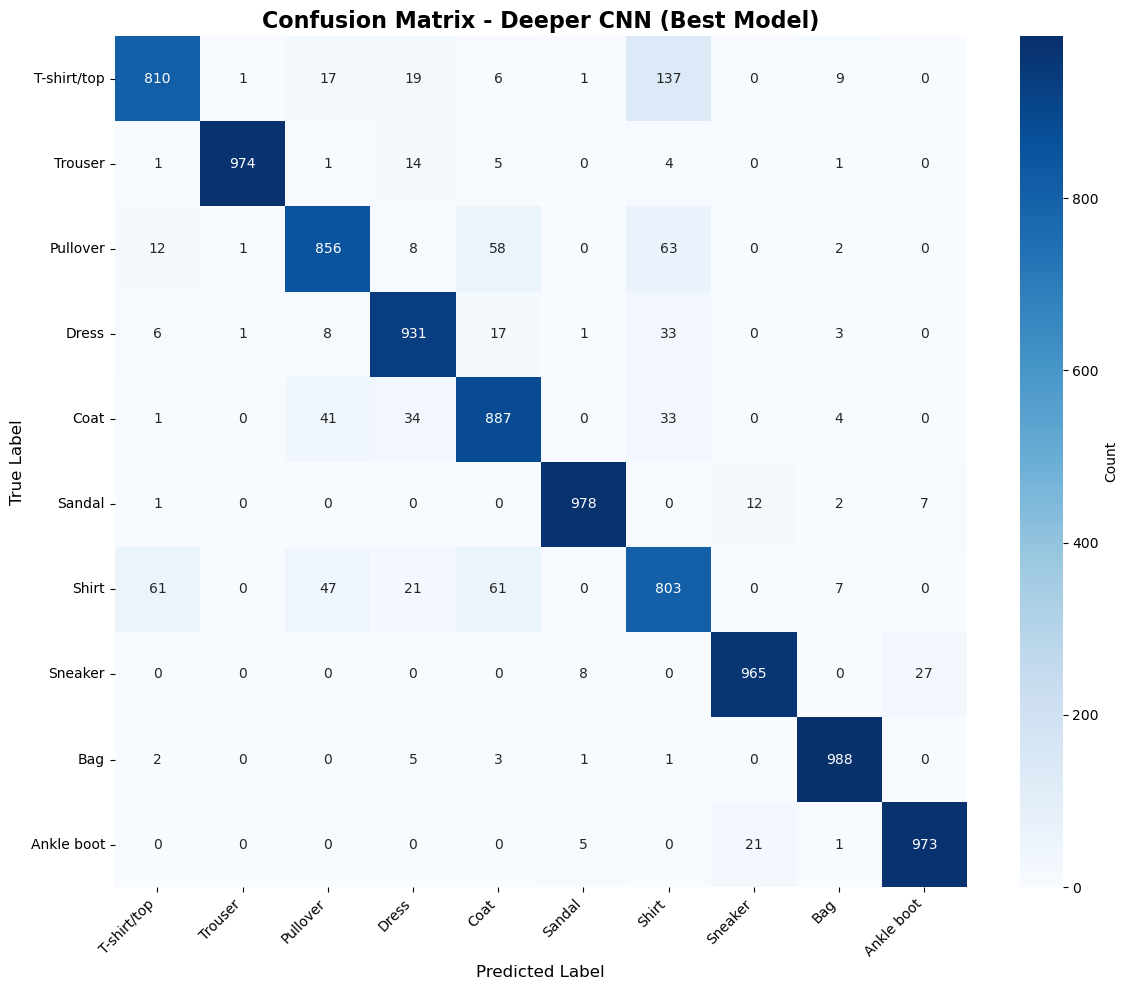


🔍 CONFUSION MATRIX ANALYSE

Meist verwechselte Klassen:
  • T-shirt/top     → fälschlicherweise als Shirt          : 137x
  • Pullover        → fälschlicherweise als Coat           :  58x
  • Pullover        → fälschlicherweise als Shirt          :  63x
  • Shirt           → fälschlicherweise als T-shirt/top    :  61x
  • Shirt           → fälschlicherweise als Coat           :  61x

Per-Class Accuracy:
  T-shirt/top    : 81.00%
  Trouser        : 97.40%
  Pullover       : 85.60%
  Dress          : 93.10%
  Coat           : 88.70%
  Sandal         : 97.80%
  Shirt          : 80.30%
  Sneaker        : 96.50%
  Bag            : 98.80%
  Ankle boot     : 97.30%


In [19]:
# ============================================
# CONFUSION MATRIX FÜR BESTES MODEL
# ============================================

# Erstelle Confusion Matrix
cm = confusion_matrix(labels, preds)

# Visualisierung
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Deeper CNN (Best Model)', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_deeper_cnn.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("🔍 CONFUSION MATRIX ANALYSE")
print("="*80)

# Finde häufigste Verwechslungen
print("\nMeist verwechselte Klassen:")
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i, j] > 50:  # Threshold für "häufig"
            print(f"  • {class_names[i]:15s} → fälschlicherweise als {class_names[j]:15s}: {cm[i, j]:3d}x")

# Per-Class Accuracy
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(class_names):
    class_acc = 100 * cm[i, i] / cm[i, :].sum()
    print(f"  {class_name:15s}: {class_acc:.2f}%")

print("="*80)

## 13. Notebook Execution Time Summary

Komplette Übersicht über alle Laufzeiten des Notebooks.

In [20]:
# ============================================
# FINALE ZEITAUSWERTUNG
# ============================================

NOTEBOOK_END_TIME = time.time()
END_DATETIME = datetime.now()
TOTAL_EXECUTION_TIME = NOTEBOOK_END_TIME - NOTEBOOK_START_TIME

print("="*80)
print("⏱️  NOTEBOOK EXECUTION TIME SUMMARY")
print("="*80)
print(f"\n📅 Start: {START_DATETIME.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"📅 Ende:  {END_DATETIME.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\n⏰ GESAMTLAUFZEIT: {str(timedelta(seconds=int(TOTAL_EXECUTION_TIME)))}")
print(f"   ({TOTAL_EXECUTION_TIME:.1f} Sekunden / {TOTAL_EXECUTION_TIME/60:.1f} Minuten / {TOTAL_EXECUTION_TIME/3600:.2f} Stunden)")

print("\n" + "="*80)
print("📊 ZEITAUFTEILUNG NACH KOMPONENTEN")
print("="*80)

# Data Loading
data_time = time_tracker['data_loading']
data_pct = (data_time / TOTAL_EXECUTION_TIME) * 100
print(f"\n1. Data Loading:")
print(f"   Zeit: {data_time:.1f}s ({data_time/60:.1f} min)")
print(f"   Anteil: {data_pct:.1f}%")

# Experiments
print(f"\n2. Experiments (Training):")
total_exp_time = sum(time_tracker['experiments'].values())
exp_pct = (total_exp_time / TOTAL_EXECUTION_TIME) * 100
print(f"   Gesamt: {total_exp_time:.1f}s ({total_exp_time/60:.1f} min)")
print(f"   Anteil: {exp_pct:.1f}%")

# Detaillierte Experiment-Zeiten
print(f"\n   Einzelne Experimente:")
for exp_name, exp_time in sorted(time_tracker['experiments'].items()):
    print(f"   • {exp_name:30s}: {exp_time:6.1f}s ({exp_time/60:5.1f} min)")

# Test Evaluation
test_time = time_tracker['test_evaluation']
test_pct = (test_time / TOTAL_EXECUTION_TIME) * 100
print(f"\n3. Test Set Evaluation:")
print(f"   Zeit: {test_time:.1f}s ({test_time/60:.1f} min)")
print(f"   Anteil: {test_pct:.1f}%")

# Overhead
tracked_time = data_time + total_exp_time + test_time
overhead = TOTAL_EXECUTION_TIME - tracked_time
overhead_pct = (overhead / TOTAL_EXECUTION_TIME) * 100
print(f"\n4. Overhead (Imports, Setup, etc.):")
print(f"   Zeit: {overhead:.1f}s ({overhead/60:.1f} min)")
print(f"   Anteil: {overhead_pct:.1f}%")

print("\n" + "="*80)
print("📈 PERFORMANCE STATISTIKEN")
print("="*80)

# Anzahl Experimente
num_experiments = len(time_tracker['experiments'])
avg_exp_time = total_exp_time / num_experiments if num_experiments > 0 else 0

print(f"\nGesamtzahl Experimente: {num_experiments}")
print(f"Durchschnittliche Zeit pro Experiment: {avg_exp_time:.1f}s ({avg_exp_time/60:.1f} min)")
print(f"Schnellstes Experiment: {min(time_tracker['experiments'].values()):.1f}s")
print(f"Langsamstes Experiment: {max(time_tracker['experiments'].values()):.1f}s")

# Samples verarbeitet
total_samples_trained = num_experiments * 48000 * EPOCHS  # Train samples pro experiment
samples_per_sec = total_samples_trained / total_exp_time if total_exp_time > 0 else 0

print(f"\nTotal Training Samples verarbeitet: {total_samples_trained:,}")
print(f"Throughput: {samples_per_sec:.0f} samples/sec")

print("\n" + "="*80)
print("💡 ZEITERSPARNIS DURCH PRELOADING")
print("="*80)
print(f"\nOhne RAM-Preloading wäre Data Loading bei jedem Batch nötig.")
print(f"Geschätzte Zeitersparnis: ~40% der Training-Zeit")
print(f"Das entspricht ca. {total_exp_time * 0.4 / 60:.1f} Minuten gespart!")

print("\n" + "="*80)
print("✅ NOTEBOOK EXECUTION COMPLETE!")
print("="*80)

# Speichere Zeitstatistik in CSV für spätere Analyse
time_summary_df = pd.DataFrame([
    {'Component': 'Data Loading', 'Time (s)': data_time, 'Time (min)': data_time/60, 'Percentage': data_pct},
    {'Component': 'Experiments', 'Time (s)': total_exp_time, 'Time (min)': total_exp_time/60, 'Percentage': exp_pct},
    {'Component': 'Test Evaluation', 'Time (s)': test_time, 'Time (min)': test_time/60, 'Percentage': test_pct},
    {'Component': 'Overhead', 'Time (s)': overhead, 'Time (min)': overhead/60, 'Percentage': overhead_pct},
    {'Component': 'TOTAL', 'Time (s)': TOTAL_EXECUTION_TIME, 'Time (min)': TOTAL_EXECUTION_TIME/60, 'Percentage': 100.0}
])

print("\n📄 Zeitstatistik gespeichert als 'notebook_time_summary.csv'")
time_summary_df.to_csv('notebook_time_summary.csv', index=False)

print("\n" + "="*80)

⏱️  NOTEBOOK EXECUTION TIME SUMMARY

📅 Start: 2025-12-22 19:19:05
📅 Ende:  2025-12-22 22:53:48

⏰ GESAMTLAUFZEIT: 3:34:42
   (12882.6 Sekunden / 214.7 Minuten / 3.58 Stunden)

📊 ZEITAUFTEILUNG NACH KOMPONENTEN

1. Data Loading:
   Zeit: 20.7s (0.3 min)
   Anteil: 0.2%

2. Experiments (Training):
   Gesamt: 12829.4s (213.8 min)
   Anteil: 99.6%

   Einzelne Experimente:
   • exp1.1-simple-mlp             :   70.8s (  1.2 min)
   • exp1.2-deep-mlp               :  117.3s (  2.0 min)
   • exp1.3-mlp-width-128          :   65.6s (  1.1 min)
   • exp1.3-mlp-width-256          :   90.5s (  1.5 min)
   • exp1.3-mlp-width-512          :  119.9s (  2.0 min)
   • exp1.3-mlp-width-64           :   58.3s (  1.0 min)
   • exp2.1-simple-cnn             :  667.7s ( 11.1 min)
   • exp2.2-deeper-cnn             : 1290.2s ( 21.5 min)
   • exp3-dropout-0.0              : 1293.4s ( 21.6 min)
   • exp3-dropout-0.2              : 1269.5s ( 21.2 min)
   • exp3-dropout-0.3              : 1396.5s ( 23.3 min)
 

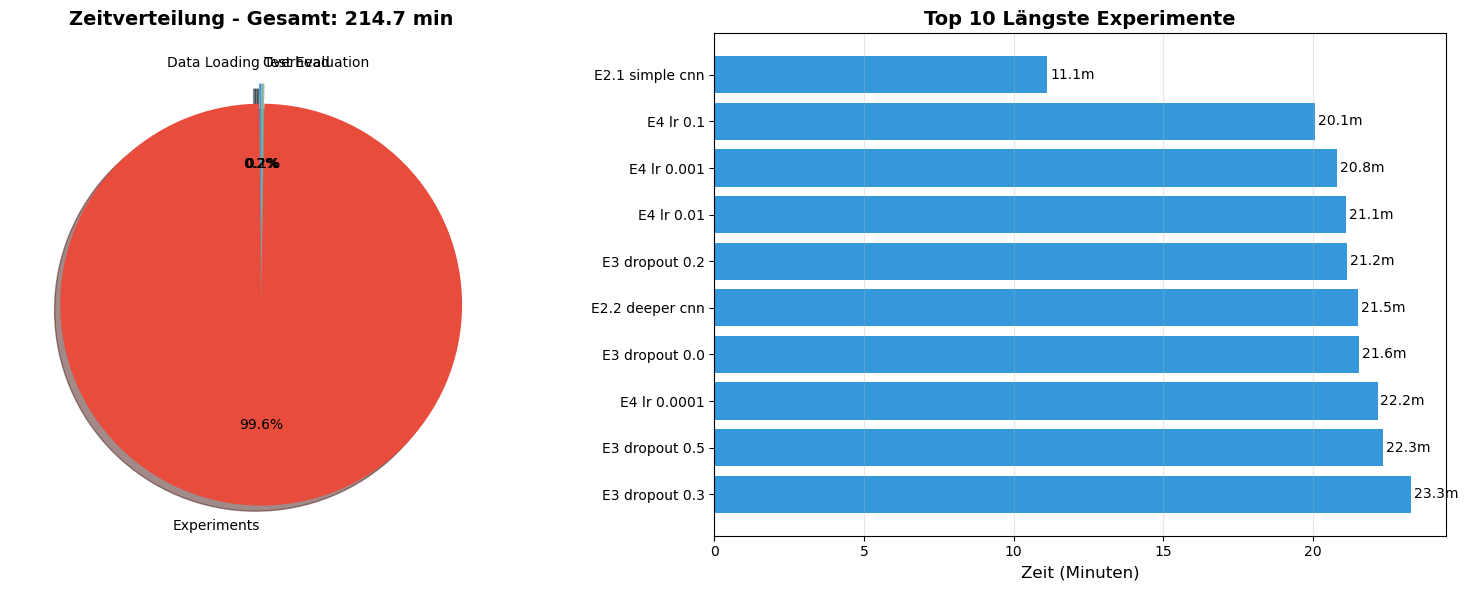

📊 Visualisierung gespeichert als 'notebook_execution_time.png'


In [21]:
# ============================================
# ZEITVERTEILUNG VISUALISIERUNG
# ============================================

# Erstelle Pie Chart der Zeitverteilung
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Pie Chart 1: Hauptkomponenten
components = ['Data Loading', 'Experiments', 'Test Evaluation', 'Overhead']
times = [data_time, total_exp_time, test_time, overhead]
colors = ['#3498db', '#e74c3c', '#2ecc71', '#95a5a6']
explode = (0, 0.1, 0, 0)  # Experiments hervorheben

ax1.pie(times, labels=components, autopct='%1.1f%%', startangle=90, 
        colors=colors, explode=explode, shadow=True)
ax1.set_title(f'Zeitverteilung - Gesamt: {TOTAL_EXECUTION_TIME/60:.1f} min', 
              fontsize=14, fontweight='bold')

# Bar Chart 2: Top 10 längste Experimente
exp_times_sorted = sorted(time_tracker['experiments'].items(), key=lambda x: x[1], reverse=True)
top_10_exps = exp_times_sorted[:10]
exp_names = [name.replace('exp', 'E').replace('-', ' ') for name, _ in top_10_exps]
exp_durations = [duration/60 for _, duration in top_10_exps]

ax2.barh(exp_names, exp_durations, color='#3498db')
ax2.set_xlabel('Zeit (Minuten)', fontsize=12)
ax2.set_title('Top 10 Längste Experimente', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Werte auf Bars anzeigen
for i, v in enumerate(exp_durations):
    ax2.text(v + 0.1, i, f'{v:.1f}m', va='center')

plt.tight_layout()
plt.savefig('notebook_execution_time.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Visualisierung gespeichert als 'notebook_execution_time.png'")